# Dynamic Delta Hedging for an ATM European Call (Black–Scholes Model)

In this notebook we implement **dynamic delta hedging** for an at-the-money European call option under the Black–Scholes framework.  
The hedge ratio (Delta) is computed numerically via Monte Carlo (bump-and-revalue), and used to replicate the option payoff along a simulated price path.

## 1. Black–Scholes framework

We consider a stock price following a geometric Brownian motion under the real-world (P) and risk-neutral (Q) measures:

\[
dS_t = \mu S_t dt + \sigma S_t dW_t^P, \quad
dS_t = r S_t dt + \sigma S_t dW_t^Q.
\]

- \(S_0\): initial spot  
- \(K\): strike (here we focus on an ATM call)  
- \(T\): maturity  
- \(r\): risk-free rate  
- \(mu\): real drift of the stock  
- \(sigma\): volatility  

Pricing and Delta are always computed under the **risk-neutral** measure with drift \(r\), while the hedging P\&L is evaluated under the **real** measure with drift \(mu\).

## 2. Monte Carlo pricing and Delta approximation

### 2.1 Monte Carlo pricing of an ATM European call

We first implement a standard Monte Carlo pricer for a European call option under the Black–Scholes model.  
The function `MC_pricing_call` returns the point estimate and a confidence interval for the discounted payoff. 

Key steps:
- Simulate terminal stock prices \(S_T\) under the risk-neutral dynamics with drift \(r\).
- Compute the discounted payoff \(\max(S_T - K, 0) e^{-rT}\).
- Average over simulations and build a normal-based confidence interval.

In [2]:
import numpy as np
from scipy.stats import norm
def MC_pricing_call(N,S0,T,k,sigma,r,alpha=0.05):
    g = np.random.randn(N)
    S = S0*np.exp((r-0.5*sigma**2)*T+sigma*g*np.sqrt(T))  # stocks at maturity
    payoff = np.maximum(0,S-k)
    disc_payoff = payoff*np.exp(-r*T)
    # MC estimate
    MC_est = disc_payoff.mean()   
    # Confidence intervals
    z = norm.ppf(1-alpha/2)
    std = np.std(disc_payoff,ddof=1)
    sup = MC_est + z*std/np.sqrt(N)
    inf = MC_est - z*std/np.sqrt(N)
    return inf, MC_est, sup

    

In [12]:
MC_pricing_call(1000000,100,5,100,0.3,0.05)

(35.80976510165155, 35.93925708011697, 36.068749058582384)

### 2.2 Monte Carlo Delta via bump-and-revalue

To compute Delta at time \(t\), we apply a **central finite-difference** scheme using Monte Carlo:

\[
\Delta(t,S_t) \approx \frac{C(S_t + h, t) - C(S_t - h, t)}{2h}.
\]

The function `Delta`:
- Perturbs the current spot by \(h\).
- Simulates terminal prices from time \(t\) to \(T\) under the risk-neutral measure.
- Computes the difference between the two discounted payoffs.

This is simple but computationally expensive, as it requires two sets of simulations per Delta evaluation.

In [4]:
def Delta(M,S,T,t,k,sigma,r,h=0.01):
    g = np.random.randn(M)
    S1 = (S+h)*np.exp((r-0.5*sigma**2)*(T-t)+sigma*g*np.sqrt(T-t))
    S2 = (S-h)*np.exp((r-0.5*sigma**2)*(T-t)+sigma*g*np.sqrt(T-t))
    P1 = np.maximum(S1-k,0) * np.exp(-r*(T-t))
    P2 = np.maximum(S2-k,0) * np.exp(-r*(T-t))
    D = (P1-P2).mean()/(2*h)
    return D

In [18]:
Delta(100000,100,5,0,100,0.15,0.04,0.01)

0.7763873921273513

## 3. Dynamic Delta hedging with Monte Carlo pricing

We now build a **self-financing hedging strategy** where:
- The option is priced by Monte Carlo at \(t=0\).
- At each rebalancing date, Delta is recomputed by Monte Carlo and used to update the stock position and the cash account.

### 3.1 Hedging algorithm

For a given number of time steps \(N\) and a single stock path \(S_t\) under the real drift \(mu\):

1. **Initialization (t = 0)**  
   - Compute initial price \(V_0\) via `MC_pricing_call`.  
   - Compute initial Delta \(\Delta_0\) via `Delta`.  
   - Set cash position \(\beta_0 = V_0 - \Delta_0 S_0\).

2. **Rebalancing (steps 1 to N–1)**  
   - Evolve the stock with drift \(\mu\).  
   - Update the portfolio value \(V_t = \Delta_{t^-} S_t + \beta_{t^-} e^{r \Delta t}\).  
   - Recompute \(\Delta_t\) with `Delta` and update \(\beta_t = V_t - \Delta_t S_t\).

3. **Final step (T)**  
   - Evolve the stock one last time.  
   - Compute final portfolio value \(V_T\) and compare it to the payoff \(max(S_T - K, 0)\).

The **hedging error** is defined as \(V_T - payoff). In continuous time and in the exact Black–Scholes world this error would vanish; in discrete time and with numerical Delta it fluctuates around zero.

In [6]:
def Dynamic_Hedging_MC(M2,M1,N,S0,T,k,sigma,r,mu):
    dt = T/N
    t = 0
    S = S0
    # step 0
    # pricing
    V = MC_pricing_call(M1,S0,T,k,sigma,r)[1]
    # delta and beta
    delta = Delta(M2,S,T,t,k,sigma,r)
    beta = V - delta*S
    # steps 1 to N-1
    for i in range(1,N):
        # time update
        t = t + dt
        # Stock update
        g = np.random.randn()
        S = S*np.exp((mu-0.5*sigma**2)*dt+sigma*g*np.sqrt(dt))
        # portfolio update
        V = delta*S + beta*np.exp(r*dt)
        # rebalance
        delta = Delta(M2,S,T,t,k,sigma,r)
        beta = V - delta*S
    # step N (last one) only portfolio update
    S = S*np.exp((mu-0.5*sigma**2)*dt+sigma*g*np.sqrt(dt))
    V = delta*S + beta*np.exp(r*dt)
    # payoff
    payoff = np.maximum(0,S-k)
    return V,(V-payoff)



In [53]:
Dynamic_Hedging_MC(100000,100000,360,100,1,100,0.15,0.4,0.7)[1]

-0.000823243915618832

### 3.2 Distribution of hedging errors (MC pricing)

We repeat the dynamic hedging experiment several times, each with a newly simulated stock path, and collect the terminal error \(V_T - payoff\).

The histogram below shows:
- The **mean** hedging error (should be close to zero in a well-specified model).
- The **dispersion** of errors due to discrete rebalancing and numerical Delta approximation.

Mean: -0.002370028573505749
Standard deviation: 0.07445356737591237


Text(0.5, 1.0, 'Portfolio-Payoff difference frequencies')

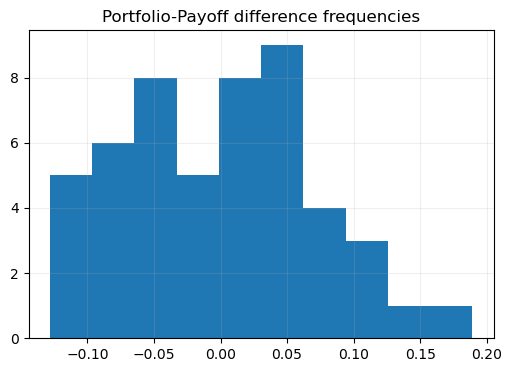

In [8]:
import matplotlib.pyplot as plt

results = []
repetitions = 50

for n in range(repetitions):
    difference = Dynamic_Hedging_MC(100000,100000,360,100,1,100,0.15,0.4,0.7)[1]
    results.append(difference)
    
results = np.array(results)

print('Mean:', np.mean(results))
print('Standard deviation:',np.std(results,ddof=1))

plt.figure(figsize=(6,4))
plt.hist(results)
plt.grid(alpha=0.2)
plt.title('Portfolio-Payoff difference frequencies')

## 4. Dynamic Delta hedging with Black–Scholes pricing and MC Delta

To isolate the impact of pricing noise, we now replace the Monte Carlo price at \(t=0\) with the **closed-form Black–Scholes price**, while keeping the Monte Carlo-based Delta for rebalancing.

- Initial option value \(V_0\) is computed via the analytical formula.  
- Rebalancing still uses `Delta`, i.e. a Monte Carlo finite-difference approximation.

This allows us to compare:
- Hedging errors when both pricing and Delta are Monte Carlo-based.
- Hedging errors when pricing is exact (BS formula) but Delta is still approximated by Monte Carlo.

In [10]:
import numpy as np
from scipy.stats import norm

def black_scholes_formula(S0, T, k, sigma, r):
    d1 = (np.log(S0/k)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    Nd1 = norm.cdf(d1, loc=0, scale=1)
    Nd2 = norm.cdf(d2, loc=0, scale=1)
    C = S0*Nd1 - k*np.exp(-r*T)*Nd2
    return C

In [12]:
def Dynamic_Hedging_MC_BS_pricing(M2,M1,N,S0,T,k,sigma,r,mu):
    dt = T/N
    t = 0
    S = S0
    # step 0
    # pricing
    V = black_scholes_formula(S0, T, k, sigma, r)
    # delta and beta
    delta = Delta(M2,S,T,t,k,sigma,r)
    beta = V - delta*S
    # steps 1 to N-1
    for i in range(1,N):
        # time update
        t = t + dt
        # Stock update
        g = np.random.randn()
        S = S*np.exp((mu-0.5*sigma**2)*dt+sigma*g*np.sqrt(dt))
        # portfolio update
        V = delta*S + beta*np.exp(r*dt)
        # rebalance
        delta = Delta(M2,S,T,t,k,sigma,r)
        beta = V - delta*S
    # step N (last one) only portfolio update
    S = S*np.exp((mu-0.5*sigma**2)*dt+sigma*g*np.sqrt(dt))
    V = delta*S + beta*np.exp(r*dt)
    # payoff
    payoff = np.maximum(0,S-k)
    return V,(V-payoff)


In [74]:
Dynamic_Hedging_MC(100000,100000,360,100,1,100,0.15,0.4,0.7)

(74.3205808367559, 0.044231290470023055)

### 4.1 Distribution of hedging errors (BS pricing, MC Delta)

We repeat the experiment and plot the distribution of \(V_T - payoff\) when:

- The **initial price** is given by the Black–Scholes formula.
- The **hedge ratio** at each time step is still computed by Monte Carlo.

Comparing this histogram with the previous one highlights how much of the error comes from pricing noise versus Delta approximation and discrete rebalancing.


Mean: 0.001030983376001302
Standard deviation: 0.009575363524447125


Text(0.5, 1.0, 'Portfolio-Payoff difference frequencies')

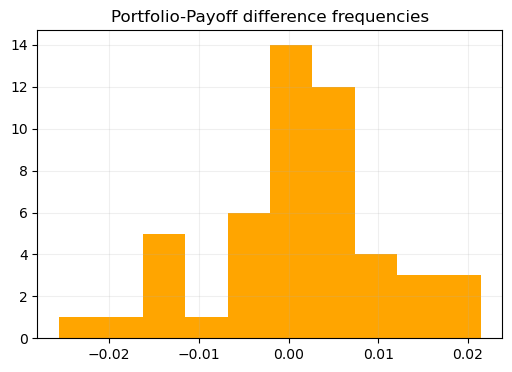

In [14]:
import matplotlib.pyplot as plt

results1 = []
repetitions = 50

for n in range(repetitions):
    difference = Dynamic_Hedging_MC_BS_pricing(100000,100000,360,100,1,100,0.15,0.4,0.7)[1]
    results1.append(difference)
    
results1 = np.array(results1)

print('Mean:', np.mean(results1))
print('Standard deviation:',np.std(results1,ddof=1))

plt.figure(figsize=(6,4))
plt.hist(results1, color = 'orange')
plt.grid(alpha=0.2)
plt.title('Portfolio-Payoff difference frequencies')

## 5. Comparing Black–Scholes Delta and Monte Carlo Delta

Finally, we directly compare:
- The analytical Black–Scholes Delta.
- The Monte Carlo Delta obtained via bump-and-revalue.

The function `Dynamic_Hedging_delta_comparison` simulates a single stock path, runs two parallel hedging strategies:

- One using the analytical Delta (BS).
- One using the Monte Carlo Delta.

At each time step we store both Deltas and plot them over time.


In [16]:
def Dynamic_Hedging_delta_comparison(M2,M1,N,S0,T,k,sigma,r,mu):
    dt = T/N
    t = 0
    S = S0
    alpha_list = []
    delta_list = []
    # step 0
    # pricing
    V = black_scholes_formula(S0, T, k, sigma, r)
    V_BS = V
    # delta and beta MC
    delta = Delta(M2,S,T,t,k,sigma,r)
    beta = V - delta*S
    # delta and beta BS
    d1 = (np.log(S/k)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    alpha = norm.cdf(d1)
    beta_BS = V-alpha*S
    # updating lists
    alpha_list.append(alpha)
    delta_list.append(delta)
    # steps 1 to N-1
    for i in range(1,N):
        # time update
        t = t + dt
        # Stock update
        g = np.random.randn()
        S = S*np.exp((mu-0.5*sigma**2)*dt+sigma*g*np.sqrt(dt))
        # MC update
        # portfolio update
        V = delta*S + beta*np.exp(r*dt)
        # rebalance
        delta = Delta(M2,S,T,t,k,sigma,r)
        beta = V - delta*S
        # BS update
        # portfolio update
        V_BS = alpha*S + beta_BS*np.exp(r*dt)
        # rebalance
        d1 = (np.log(S/k)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
        alpha = norm.cdf(d1)
        beta_BS = V_BS-alpha*S
        # lists update
        alpha_list.append(alpha)
        delta_list.append(delta)
    alpha_arr = np.array(alpha_list)
    delta_arr = np.array(delta_list)
    return alpha_arr, delta_arr
    

### 5.1 Delta path visualization

The plots below shows:

- A smooth **BS Delta** curve along the simulated path.  
- A more noisy **MC Delta** curve, fluctuating around the analytical one.

Increasing the number of simulations \(M\) in `Delta` reduces the Monte Carlo noise and makes \(\Delta^{MC}\) converge towards \(\Delta^{BS}\), while decreasing \(M\) amplifies the zig-zag behavior.


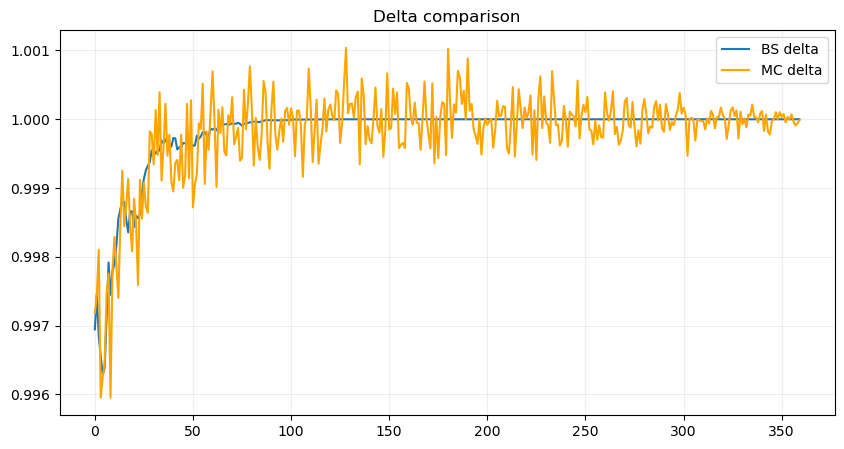

In [97]:
import matplotlib.pyplot as plt

alpha , delta = Dynamic_Hedging_delta_comparison(100000,100000,360,100,1,100,0.15,0.4,0.7)
plt.figure(figsize=(10,5))
plt.plot(alpha, label = 'BS delta')
plt.plot(delta, color = 'orange', label = 'MC delta')
plt.legend()
plt.title('Delta comparison')
plt.grid(alpha=0.2)


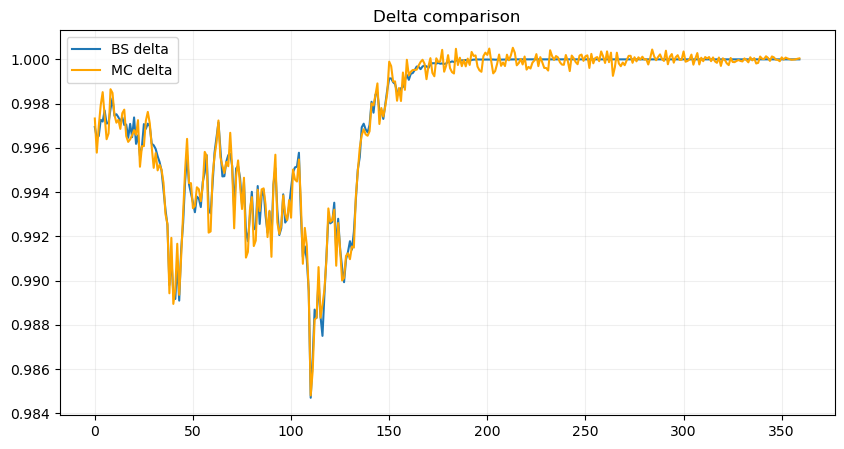

In [18]:
import matplotlib.pyplot as plt

alpha , delta = Dynamic_Hedging_delta_comparison(100000,100000,360,100,1,100,0.15,0.4,0.7)
plt.figure(figsize=(10,5))
plt.plot(alpha, label = 'BS delta')
plt.plot(delta, color = 'orange', label = 'MC delta')
plt.legend()
plt.title('Delta comparison')
plt.grid(alpha=0.2)